In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
CV_FOLDS = 5
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load gene expression and metadata
data_path = r"c:\Users\ozeir\vsrepo\ai-brain-tumor\data\raw"
gene_expr = pd.read_csv(f"{data_path}/gene_expression.csv", index_col=0)
metadata = pd.read_csv(f"{data_path}/metadata.csv")

print(f"Gene expression shape: {gene_expr.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"\nClass distribution:")
print(metadata['label'].value_counts())
print(f"\nHealthy: {(metadata['label'] == 1).sum()} ({(metadata['label'] == 1).sum() / len(metadata) * 100:.1f}%)")
print(f"Tumor: {(metadata['label'] == 0).sum()} ({(metadata['label'] == 0).sum() / len(metadata) * 100:.1f}%)")

Gene expression shape: (18635, 18858)
Metadata shape: (18635, 3)

Class distribution:
label
1    17382
0     1253
Name: count, dtype: int64

Healthy: 17382 (93.3%)
Tumor: 1253 (6.7%)


## 2. Prepare Data

In [3]:
# Determine correct data orientation
if gene_expr.shape[0] == len(metadata):
    X = gene_expr.values  # Already samples × genes
    y = metadata['label'].values
    print(f"Data orientation: samples × genes")
    
elif gene_expr.shape[1] == len(metadata):
    X = gene_expr.T.values  # Transpose to samples × genes
    y = metadata['label'].values
    print(f"Data orientation: genes × samples (transposed)")
    
else:
    raise ValueError(f"Cannot match gene_expr shape {gene_expr.shape} with metadata length {len(metadata)}")

print(f"X (samples × genes): {X.shape}")
print(f"y (labels): {y.shape}")

print(f"\nClass distribution:")
print(f"  Healthy (1): {np.sum(y == 1)} ({np.sum(y == 1) / len(y) * 100:.1f}%)")
print(f"  Tumor (0): {np.sum(y == 0)} ({np.sum(y == 0) / len(y) * 100:.1f}%)")

Data orientation: samples × genes
X (samples × genes): (18635, 18858)
y (labels): (18635,)

Class distribution:
  Healthy (1): 17382 (93.3%)
  Tumor (0): 1253 (6.7%)


## 3. Train/Test Split (FIRST STEP - LEAK PREVENTION)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 14908 samples
Test set: 3727 samples


## 4. Leak-Free Cross-Validation

**Critical**: Feature selection and scaling fitted ONLY on training fold, then applied to validation fold

In [5]:
cv_splitter = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

fold_scores_acc = []
fold_scores_auc = []

for fold_num, (train_idx, val_idx) in enumerate(cv_splitter.split(X_train, y_train), 1):
    
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Feature selection on training fold only
    selector = SelectKBest(f_classif, k=120)
    X_tr_sel = selector.fit_transform(X_tr, y_tr)
    X_val_sel = selector.transform(X_val)
    
    # Scaling on training fold only
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr_sel)
    X_val_scaled = scaler.transform(X_val_sel)
    
    # Train and evaluate
    rf_model_fold = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced"
    )
    rf_model_fold.fit(X_tr_scaled, y_tr)
    
    y_pred_val = rf_model_fold.predict(X_val_scaled)
    y_pred_val_proba = rf_model_fold.predict_proba(X_val_scaled)[:, 1]
    
    fold_acc = accuracy_score(y_val, y_pred_val)
    fold_auc = roc_auc_score(y_val, y_pred_val_proba)
    
    fold_scores_acc.append(fold_acc)
    fold_scores_auc.append(fold_auc)
    
    print(f"Fold {fold_num}/{CV_FOLDS} - Accuracy: {fold_acc:.4f}, ROC-AUC: {fold_auc:.4f}")

print(f"\nCross-Validation Results:")
print(f"  Accuracy: {np.mean(fold_scores_acc):.4f} ± {np.std(fold_scores_acc):.4f}")
print(f"  ROC-AUC: {np.mean(fold_scores_auc):.4f} ± {np.std(fold_scores_auc):.4f}")

Fold 1/5 - Accuracy: 1.0000, ROC-AUC: 1.0000
Fold 2/5 - Accuracy: 1.0000, ROC-AUC: 1.0000
Fold 2/5 - Accuracy: 1.0000, ROC-AUC: 1.0000
Fold 3/5 - Accuracy: 1.0000, ROC-AUC: 1.0000
Fold 3/5 - Accuracy: 1.0000, ROC-AUC: 1.0000
Fold 4/5 - Accuracy: 1.0000, ROC-AUC: 1.0000
Fold 4/5 - Accuracy: 1.0000, ROC-AUC: 1.0000
Fold 5/5 - Accuracy: 1.0000, ROC-AUC: 1.0000

Cross-Validation Results:
  Accuracy: 1.0000 ± 0.0000
  ROC-AUC: 1.0000 ± 0.0000
Fold 5/5 - Accuracy: 1.0000, ROC-AUC: 1.0000

Cross-Validation Results:
  Accuracy: 1.0000 ± 0.0000
  ROC-AUC: 1.0000 ± 0.0000


## 5. Train Final Model on Full Training Set

In [6]:
# Feature selection
selector_final = SelectKBest(f_classif, k=120)
X_train_sel_final = selector_final.fit_transform(X_train, y_train)
X_test_sel_final = selector_final.transform(X_test)

# Scaling
scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_sel_final)
X_test_scaled_final = scaler_final.transform(X_test_sel_final)

# Train final model
rf_model_final = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"
)
rf_model_final.fit(X_train_scaled_final, y_train)

print(f"Final model trained: {X_train.shape[1]} → {X_train_sel_final.shape[1]} features")

Final model trained: 18858 → 120 features


## 6. Final Evaluation on Test Set

In [7]:
# Predict on test set
y_pred = rf_model_final.predict(X_test_scaled_final)
y_pred_proba = rf_model_final.predict_proba(X_test_scaled_final)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  ROC-AUC: {test_auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Tumor', 'Healthy']))

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:")
print(cm)

Test Set Performance:
  Accuracy: 1.0000
  ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

       Tumor       1.00      1.00      1.00       251
     Healthy       1.00      1.00      1.00      3476

    accuracy                           1.00      3727
   macro avg       1.00      1.00      1.00      3727
weighted avg       1.00      1.00      1.00      3727

Confusion Matrix:
[[ 251    0]
 [   0 3476]]


## 7. Visualizations

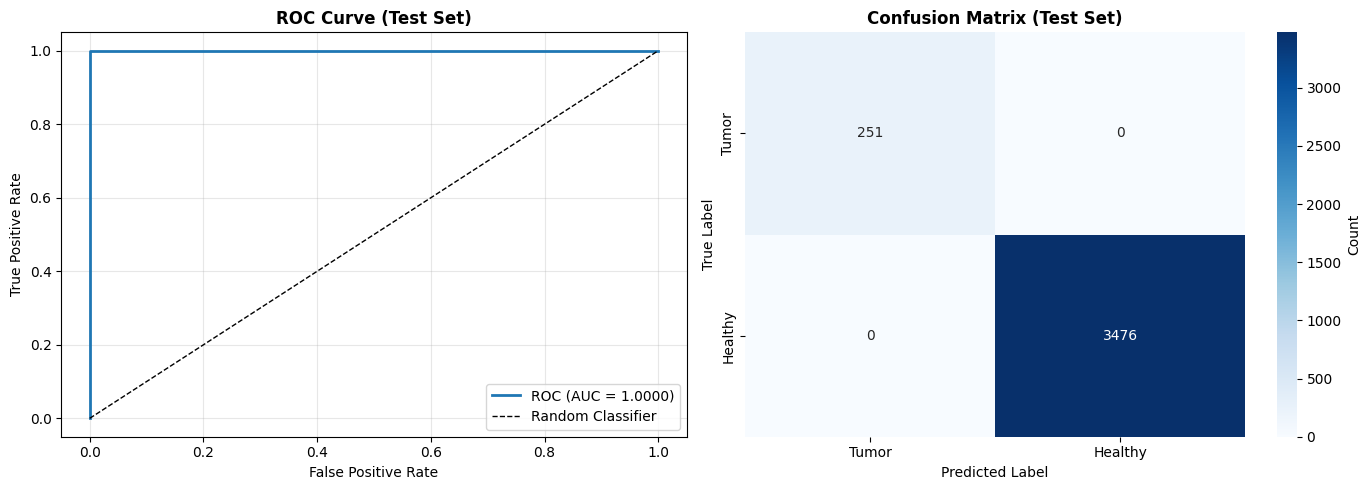

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (Test Set)', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Confusion Matrix
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Tumor', 'Healthy'],
    yticklabels=['Tumor', 'Healthy'],
    ax=axes[1],
    cbar_kws={'label': 'Count'}
)
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Test Set)', fontweight='bold')

plt.tight_layout()
plt.savefig(r"c:\Users\ozeir\vsrepo\ai-brain-tumor\figures\modeling\proper_modeling_results.png", dpi=300, bbox_inches='tight')
plt.show()

## 8. Feature Importance Analysis

Top 20 Most Important Features:
              gene  importance
 ENSG00000265806.1    0.128753
 ENSG00000198952.8    0.104615
 ENSG00000231503.4    0.072374
ENSG00000182196.13    0.056125
 ENSG00000266852.2    0.054444
ENSG00000130640.13    0.054179
 ENSG00000256393.1    0.050734
 ENSG00000251720.1    0.049887
 ENSG00000266017.1    0.048623
 ENSG00000227063.5    0.033001
 ENSG00000266643.1    0.028427
 ENSG00000266392.1    0.028313
 ENSG00000244125.1    0.027008
ENSG00000169727.12    0.026479
 ENSG00000200714.1    0.023088
 ENSG00000207547.1    0.021880
 ENSG00000263675.1    0.019096
 ENSG00000248256.1    0.018794
 ENSG00000265917.1    0.018017
 ENSG00000283676.1    0.012052


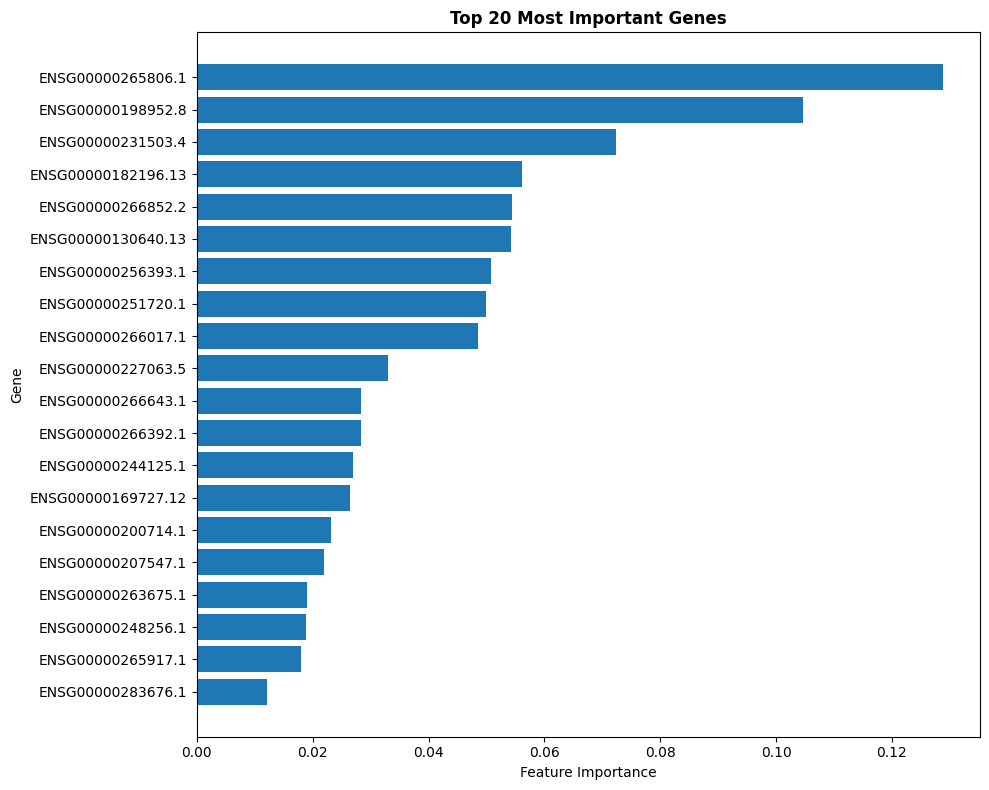

In [10]:
# Get feature importances
feature_importances = rf_model_final.feature_importances_
selected_features_mask = selector_final.get_support()
selected_feature_names = gene_expr.columns[selected_features_mask].tolist()

importance_df = pd.DataFrame({
    'gene': selected_feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(20), top_features['importance'].values)
plt.yticks(range(20), top_features['gene'].values)
plt.xlabel('Feature Importance')
plt.ylabel('Gene')
plt.title('Top 20 Most Important Genes', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(r"c:\Users\ozeir\vsrepo\ai-brain-tumor\figures\modeling\feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()


## 9. Summary & Interpretation

In [14]:
print("MODELING SUMMARY")

print(f"\nDataset:")
print(f"  Total samples: {len(X)}")
print(f"  Training: {len(X_train)}, Test: {len(X_test)}")
print(f"  Features: {X.shape[1]} → {X_train_sel_final.shape[1]} (selected)")

print(f"\nModel: Random Forest (n=100, balanced)")
print(f"  Feature selection: SelectKBest (k=120)")
print(f"  Scaling: StandardScaler")

print(f"\nCross-Validation (5-Fold):")
print(f"  Accuracy: {np.mean(fold_scores_acc):.4f} ± {np.std(fold_scores_acc):.4f}")
print(f"  ROC-AUC: {np.mean(fold_scores_auc):.4f} ± {np.std(fold_scores_auc):.4f}")

print(f"\nTest Set:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  ROC-AUC: {test_auc:.4f}")

print(f"\nLIMITATION:")
print(f"  Perfect batch-label confounding (GTEx=healthy, TCGA=tumor)")
print(f"  High performance likely from BATCH EFFECTS, not biology")


MODELING SUMMARY

Dataset:
  Total samples: 18635
  Training: 14908, Test: 3727
  Features: 18858 → 120 (selected)

Model: Random Forest (n=100, balanced)
  Feature selection: SelectKBest (k=120)
  Scaling: StandardScaler

Cross-Validation (5-Fold):
  Accuracy: 1.0000 ± 0.0000
  ROC-AUC: 1.0000 ± 0.0000

Test Set:
  Accuracy: 1.0000
  ROC-AUC: 1.0000

LIMITATION:
  Perfect batch-label confounding (GTEx=healthy, TCGA=tumor)
  High performance likely from BATCH EFFECTS, not biology
